#############################################################################
### Търсене и извличане на информация. Приложение на дълбоко машинно обучение
### Стоян Михов
### Зимен семестър 2024/2025
#############################################################################

### Упражнение 7
###
### За да работи програмата трябва корпуса от публицистични текстове за Югоизточна Европа,
### да се намира разархивиран в директорията, в която е програмата (виж упражнение 2).

### Преди да се стартира програмата е необходимо да се активира съответното обкръжение с командата:
###
### conda activate tii
###
###
### ВАЖНО!!!
### Настоящата програма използва библиотеката sklearn
### За да я инсталирате, след активиране на обкръжението трябва да изпълните командата:
###
### conda install scikit-learn
###


In [1]:
import nltk
from nltk.corpus import PlaintextCorpusReader
import sys
import random
import math
import pprint

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

import numpy as np
from sklearn.decomposition import IncrementalPCA
from sklearn.decomposition import TruncatedSVD

In [2]:
class progressBar:
    def __init__(self ,barWidth = 50):
        self.barWidth = barWidth
        self.period = None
    def start(self, count):
        self.item=0
        self.period = int(count / self.barWidth)
        sys.stdout.write("["+(" " * self.barWidth)+"]")
        sys.stdout.flush()
    def tick(self):
        if self.item>0 and self.item % self.period == 0:
            progress = self.item // self.period
            sys.stdout.write(f"\r[{'-'* progress}{' '*(self.barWidth - progress)}]")
            sys.stdout.flush()
        self.item += 1
    def stop(self):
        sys.stdout.write("\r["+("-" * self.barWidth)+"]\n")

In [3]:
def extractDictionary(corpus, limit=20000):
    pb = progressBar()
    pb.start(len(corpus))
    dictionary = {}
    for doc in corpus:
        pb.tick()
        for w in doc:
            if w not in dictionary: dictionary[w] = 0
        dictionary[w] += 1
    L = sorted([(w,dictionary[w]) for w in dictionary], key = lambda x: x[1] , reverse=True)
    if limit > len(L): limit = len(L)
    words = [ w for w,_ in L[:limit] ]
    word2ind = { w:i for i,w in enumerate(words)}
    pb.stop()
    return words, word2ind


def co_occurrence_matrix(corpus, window_size=4, limit=20000):
    words, word2ind = extractDictionary(corpus,limit=limit)
    num_words = len(words)
    
    X=np.zeros((num_words,num_words))
    
    pb = progressBar()
    pb.start(len(corpus))
    for doc in corpus:
        pb.tick()
        for wi in range(len(doc)):
            if doc[wi] not in word2ind: continue
            i=word2ind[doc[wi]]
            for k in range(1,window_size+1):
                if wi-k>=0 and doc[wi-k] in word2ind:
                    j=word2ind[doc[wi-k]]
                    X[i,j] += 1
                if wi+k<len(doc) and doc[wi+k] in word2ind:
                    j=word2ind[doc[wi+k]]
                    X[i,j] += 1
    pb.stop()
    return X, words, word2ind

def PMI_matrix(C):
    rowSums = np.sum(C,axis=1)
    colSums = np.sum(C,axis=0)
    D = np.sum(rowSums)
    Z = np.outer(rowSums,colSums)
    X = np.maximum(np.log( D * C / Z),0)
    return X

def PCA_k_dim(X, k=2):
    # Документация на метода има на https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.IncrementalPCA.html

    print("Running Incremental PCA over %i words..." % (X.shape[0]))
    X0 = X - np.mean(X, axis=0)
    pca = IncrementalPCA(n_components=k)
    pca.fit(X0)
    X_reduced = pca.transform(X0)
    print("Done.")
    return X_reduced

def SVD_k_dim(X, k=100, n_iters = 10):
    # Документация на метода има на https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html
    
    print("Running Truncated SVD over %i words..." % (X.shape[0]))
    svd = TruncatedSVD(n_components=k, n_iter=n_iters)
    svd.fit(X)
    X_reduced = svd.transform(X)
    print("Done.")
    return X_reduced

In [4]:
def plot_embeddings(M, word2ind, words):
    xs = M[:,0]
    ys = M[:,1]
    for w in words:
        i=word2ind[w]
        plt.scatter(xs[i],ys[i], marker='x', color= 'red')
        plt.text(xs[i]+0.001, ys[i]+0.001, w)
    plt.show()

def plot_embeddings_3d(M, word2ind, words):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    xs = M[:,0]
    ys = M[:,1]
    zs = M[:,2]
    for w in words:
        i=word2ind[w]
        ax.scatter(xs[i], ys[i], zs[i], marker='x', color= 'red')
        ax.text(xs[i]+0.001, ys[i]+0.001, zs[i]+0.001, w)
    plt.show()

#   Пълен пример

<>:2: SyntaxWarning: invalid escape sequence '\.'
<>:2: SyntaxWarning: invalid escape sequence '\.'
/tmp/ipykernel_2756/77125134.py:2: SyntaxWarning: invalid escape sequence '\.'
  myCorpus = PlaintextCorpusReader(corpus_root, '.*\.txt')


[--------------------------------------------------]
[--------------------------------------------------]


/tmp/ipykernel_2756/2882300669.py:46: RuntimeWarning: divide by zero encountered in log
  X = np.maximum(np.log( D * C / Z),0)


Running Truncated SVD over 20000 words...
Done.


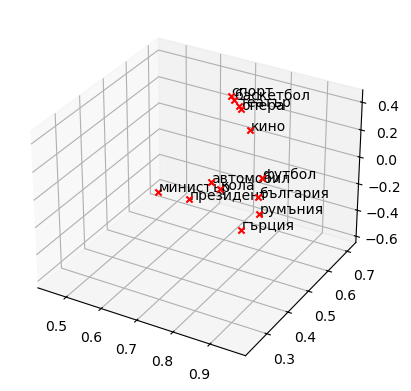

In [5]:
corpus_root = 'JOURNALISM.BG/C-MassMedia'
myCorpus = PlaintextCorpusReader(corpus_root, '.*\.txt')
startToken = '<START>'
endToken = '<END>'
corpus =  [[startToken] + [w.lower() for w in myCorpus.words(f)] + [endToken] for f in myCorpus.fileids()]

C, words, word2ind = co_occurrence_matrix(corpus)
X = PMI_matrix(C)
X_reduced = SVD_k_dim(X)
X_reduced_3d = X_reduced[:,:3]
X_lengths_3d = np.linalg.norm(X_reduced_3d, axis=1)
X_normalized_3d = X_reduced_3d / X_lengths_3d[:, np.newaxis]
sampleWords = ['кола', 'автомобил', 'румъния', 'министър', 'президент', 'гърция', 'футбол', 'спорт', 'баскетбол', 'българия', 'театър', 'кино', 'опера']

plot_embeddings_3d(X_normalized_3d, word2ind, sampleWords)

X_lengths_100d = np.linalg.norm(X_reduced, axis=1)
X_normalized_100d = X_reduced / X_lengths_100d[:, np.newaxis]

In [6]:
def most_similar(w,word2ind,words,C,limit=10):
    i = word2ind[w]
    L = np.dot(C,C[i]).tolist()
    L = sorted([(words[i],s) for i,s in enumerate(L)], key = lambda x: x[1] , reverse=True)
    return L[:limit]

pprint.pprint(most_similar('гърция',word2ind,words,X_normalized_100d))
pprint.pprint(most_similar('футбол',word2ind,words,X_normalized_100d))
pprint.pprint(most_similar('камион',word2ind,words,X_normalized_100d))

[('гърция', 0.9999999999999999),
 ('турция', 0.7620394974871402),
 ('албания', 0.7532214855174885),
 ('атина', 0.7444825456816085),
 ('кипър', 0.7366932175997397),
 ('хърватия', 0.7301361111757118),
 ('българия', 0.7200667416572991),
 ('македония', 0.7128888290701195),
 ('румъния', 0.7128389823006127),
 ('страната', 0.689336330613913)]
[('футбол', 1.0000000000000004),
 ('отбор', 0.8615927478891527),
 ('баскетбол', 0.8473752988419709),
 ('хандбал', 0.8420364104848552),
 ('топка', 0.818423472943811),
 ('квалификациите', 0.79932136724388),
 ('отборът', 0.7971193680221128),
 ('волейбол', 0.7873462419029706),
 ('водна', 0.7794637859272713),
 ('отбора', 0.7733817800970756)]
[('камион', 1.0),
 ('автомобил', 0.8752892777881985),
 ('кола', 0.8192164503816672),
 ('колата', 0.7962760361607458),
 ('влак', 0.7956197844875278),
 ('скрити', 0.7851816154936548),
 ('контейнер', 0.7779389674945217),
 ('огън', 0.7705343057401822),
 ('скрит', 0.7647874903438817),
 ('шофиран', 0.7509523899766936)]


In [35]:
def naiveSeed(X, K):
    return X[np.random.choice(np.arange(X.shape[0]),K)]
    
def Kmeans(X, K, selectSeed, maxIter=100, minRSSDelta=1e-4):
    #### X : Тензор с размер SxN, където S е броя на векторите, а N е размерността на векторите
    #### K : брой на клъстерите

    M = selectSeed(X, K) # размерността на M е KxN
    RSS=1e100

    iter=0

    while iter < 2 or (RSS0 - RSS > minRSSDelta  and iter < maxIter):
        RSS0=RSS

        M1 = np.expand_dims(M,axis=1) # размерността на M1 е Kx1xN
        
        X1 = np.expand_dims(X,axis=0) # размерността на X1 е 1xSxN
        
        XM = X1 - M1                  # размерността на XM е KxSxN
            
        R = np.sum(XM ** 2, axis=2)   # размерността на R е KxS -- k-тия ред ни дава разстоянието на квадрат на j-тия вектор до k-тия центроид M[k]

        W = np.argmin(R, axis=0)      # W е S-мерен вектор -- всеки елемент ни дава индекса на най-близкия центроид

        RS = R[W,np.arange(R.shape[1])] # квадрата на разстоянието до най-близкия центроид

        RSS = np.sum(RS)
        
        print(iter,RSS)
        
        M = np.stack([ np.mean(X[np.where(W==k)],axis=0) for k in range(K) ])
            # np.where(W==k) връща вектор от индексите i на W, за които W[i] == k
            # X[np.where(W==k)] е матрицата, от векторите (редове) на X, които са най-близко до k-тия центроид M[k]
            # np.mean(X[np.where(W==k)],axis=0) е центроида на векторите най-близко до M[k]
            # Накрая съставяме новата матрица M като събираме получените нови центроиди
        
        iter += 1
    return M, RSS

In [20]:
fileNames = myCorpus.fileids()
ecoCorpus = [ [startToken] + [w.lower() for w in myCorpus.words(f)] + [endToken] for f in fileNames if f.find('E-Economy'+'/')==0 ]
milCorpus = [ [startToken] + [w.lower() for w in myCorpus.words(f)] + [endToken] for f in fileNames if f.find('S-Military'+'/')==0 ]
culCorpus = [ [startToken] + [w.lower() for w in myCorpus.words(f)] + [endToken] for f in fileNames if f.find('C-Culture'+'/')==0 ]
polCorpus = [ [startToken] + [w.lower() for w in myCorpus.words(f)] + [endToken] for f in fileNames if f.find('J-Politics'+'/')==0 ]

corpus = ecoCorpus[:100]+milCorpus[:100]+culCorpus[:100]

In [21]:
def docVector(document, Embedding, word2ind):
    tf = np.zeros(len(word2ind))
    for w in document:
        if w in word2ind:
            tf[word2ind[w]] += 1
    return np.dot(tf,Embedding)

def corpusEmbedding(corpus, Embedding, word2ind):
    return np.stack([ docVector(doc, Embedding, word2ind) for doc in corpus ])

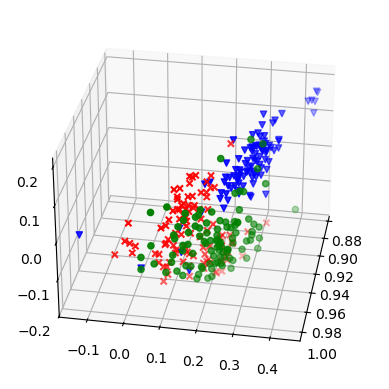

In [34]:
# 
CE = corpusEmbedding(corpus, X_normalized_100d, word2ind)
CE_3d = CE[:,:3]
CE_3d = CE_3d / np.linalg.norm(CE_3d, axis=1)[:, np.newaxis]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(CE_3d[:100,0], CE_3d[:100,1], CE_3d[:100,2], marker='x', color= 'red')
ax.scatter(CE_3d[100:200,0], CE_3d[100:200,1], CE_3d[100:200,2], marker='o', color= 'green')
ax.scatter(CE_3d[200:,0], CE_3d[200:,1], CE_3d[200:,2], marker='v', color= 'blue')
ax.view_init(30, 10, 0)
plt.show()

0 3.0045839737963096
1 1.7118781860676187
2 1.601784628042798
3 1.5517658690460383
4 1.533166120344501
5 1.5277148372106393
6 1.5266416505253035
7 1.5266416505253035


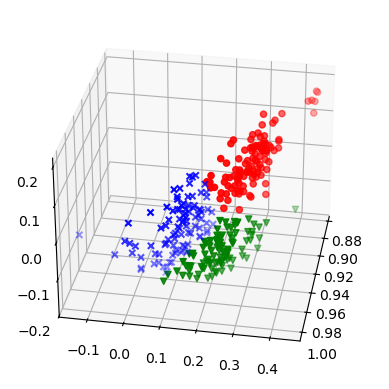

In [33]:
M = Kmeans(CE_3d, 3, naiveSeed)
R = np.sum((np.expand_dims(CE_3d,axis=0) - np.expand_dims(M,axis=1) ) ** 2, axis=2)
W = np.argmin(R, axis=0)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(CE_3d[np.where(W==0),0], CE_3d[np.where(W==0),1], CE_3d[np.where(W==0),2], marker='x', color= 'blue')
ax.scatter(CE_3d[np.where(W==1),0], CE_3d[np.where(W==1),1], CE_3d[np.where(W==1),2], marker='o', color= 'red')
ax.scatter(CE_3d[np.where(W==2),0], CE_3d[np.where(W==2),1], CE_3d[np.where(W==2),2], marker='v', color= 'green')
ax.view_init(30, 10, 0)
plt.show()


In [24]:
fullCorpus = ecoCorpus + milCorpus + culCorpus + polCorpus
fCE = corpusEmbedding(fullCorpus, X_normalized_100d, word2ind)
fCE = fCE / np.linalg.norm(fCE, axis=1)[:, np.newaxis]

fM = Kmeans(fCE, 4, naiveSeed)
fR = np.sum((np.expand_dims(fCE,axis=0) - np.expand_dims(fM,axis=1) ) ** 2, axis=2)
fW = np.argmin(fR, axis=0)

0 606.1388239844111
1 374.92079810880887
2 359.0484288427225
3 357.5304693565478
4 356.72930749551074
5 355.92926811921325
6 355.13770966131085
7 354.39408129729713
8 354.0204669143201
9 353.87156843838557
10 353.8004605015609
11 353.77295420485
12 353.7642744150304
13 353.75877950944096
14 353.7572096256989
15 353.75681545274097
16 353.7560028423232
17 353.75560596992625
18 353.75560596992625


In [25]:
confusionMatrix = np.zeros((4,4),dtype='int32')
classCounts = [len(ecoCorpus), len(milCorpus), len(culCorpus), len(polCorpus)]
for i in range(len(classCounts)):
    sumUpToNow = sum(classCounts[:i])
    for d in range(sumUpToNow, sumUpToNow + classCounts[i]):
        confusionMatrix[i,fW[d]] += 1

classes = ['Economy','Military','Culture','Politics']
print('Матрица на обърквания: ')
print('{:8}'.format(''), end = '')
for col in range(confusionMatrix.shape[1]):
    print('{:8}'.format('      #'+str(col)), end = '')
print()
for row in range(confusionMatrix.shape[0]):
    print('{:8}'.format(classes[row]), end = '')
    for col in range(confusionMatrix.shape[1]):
        print('{:8}'.format(confusionMatrix[row,col]), end = '')
    print()



Матрица на обърквания: 
              #0      #1      #2      #3
Economy       34     298      44     276
Military       4     592     760     230
Culture      399      18       9      29
Politics      17    5465     282    1595


In [42]:
results : list[float] = []
for k in range(2, 10):
    _, RSS = Kmeans(fCE, k, naiveSeed)
    results.append(RSS)


0 719.6099357935436
1 419.59327353896174
2 416.8297517720704
3 416.21195668810253
4 415.99425358470717
5 415.9065372515066
6 415.85524181494634
7 415.82726133164266
8 415.8128183949631
9 415.80473820344025
10 415.8016179753382
11 415.79977499877697
12 415.79838226749223
13 415.7975642126287
14 415.797064185184
15 415.7967163771532
16 415.796592782111
17 415.7963930443132
18 415.79570403857167
19 415.7945864766113
20 415.7935825504318
21 415.7934997601076
0 631.8528371762397
1 411.69935365832276
2 393.95902286969465
3 387.94054819975497
4 383.16878342319626
5 380.46190961920433
6 379.23807475179365
7 378.58990913703343
8 378.2444221347371
9 378.0372043012168
10 377.89716047663336
11 377.83619706301124
12 377.80451759298296
13 377.77720440668236
14 377.7467180454002
15 377.7286499038951
16 377.7204723909574
17 377.71565074330334
18 377.7125975859154
19 377.71033749677815
20 377.70970106359107
21 377.7095804670043
22 377.7095804670043
0 583.3273236442787
1 367.95676498276464
2 356.2541098

In [43]:
results

[np.float64(415.7934997601076),
 np.float64(377.7095804670043),
 np.float64(351.55162788901043),
 np.float64(337.9692564564549),
 np.float64(313.9945663973098),
 np.float64(321.3676818076673),
 np.float64(302.73096554047027),
 np.float64(291.41189423234323)]